# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings
import math
import progressbar

warnings.filterwarnings("ignore")
sns.set()
bar = progressbar.ProgressBar(maxval=100, \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stop_words = set(stopwords.words('english'))
snow = SnowballStemmer('english')
pre_processed = []

i = 0
bar.maxval = len(data['Text'])
bar.start()
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence)
    sentence = re.sub('</br>', ' ', sentence) # br tag
    sentence = re.sub('\s+',' ', sentence)
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stop_words]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    bar.update(i)
    i += 1

data['Text'] = pre_processed
bar.finish()

[========================================================================] 100%


### Data Segmentation

* First 10k review taken into consideration.
* Taken only text column from data.
* Data is divided according to time.

In [5]:
data = data['Text'][0:10000]

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [6]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=2000)
bow_data = bow_model.fit_transform(data)

## Clustering 

* Clustering text data into different clusters.
* Clustered using KMeans from sklearn.cluster module.
* Trained on bag of words data.

### KMeans++

* Algorithm for calculating intial values in KMeans.

In [7]:
from sklearn.cluster import KMeans

squared_distances = []
for i in range(8, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=3)
    kmeans.fit(bow_data)
    squared_distances.append(kmeans.inertia_)

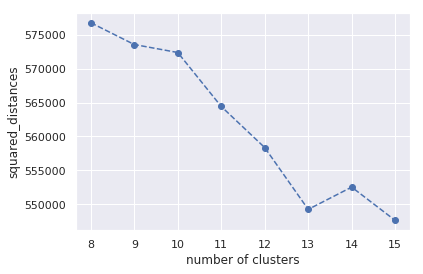

In [8]:
# plot 
te = [i for i in range(8,16)]
plt.plot(te, squared_distances, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- According to elbow method, best model is of 10 clusters.

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, init='k-means++', n_jobs=3)
kmeans.fit(bow_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
from prettytable import PrettyTable
from CustomModules import Dunn

dunn_index = Dunn.cal_dunnIndex(bow_data, kmeans.cluster_centers_, kmeans.labels_)
performence = []
performence.append(['Algo', 'num of clusters', 'squared distances', 'Dunn Index'])
performence.append(['KMeans++', 13, round(kmeans.inertia_, 2), 
                    round(dunn_index, 2)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [11]:
# loading not preprocessed data
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')
original_data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)

# removing duplicates
original_data = original_data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

In [12]:
labels = kmeans.labels_
cluster_data = [[] for i in range(13)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [13]:
# saving 5th and 9th cluster data into text file
with open('Saved/cluter5.txt', 'w') as f:
    for sentence in cluster_data[4]:
        f.write(sentence)
        f.write('\n')
        
with open('Saved/cluter9.txt', 'w') as f:
    for sentence in cluster_data[8]:
        f.write(sentence)
        f.write('\n')

- Observed that text in cluster 5 has appreciations towards product.
- Cluster 7 has large size reviews and positive opinions on product.

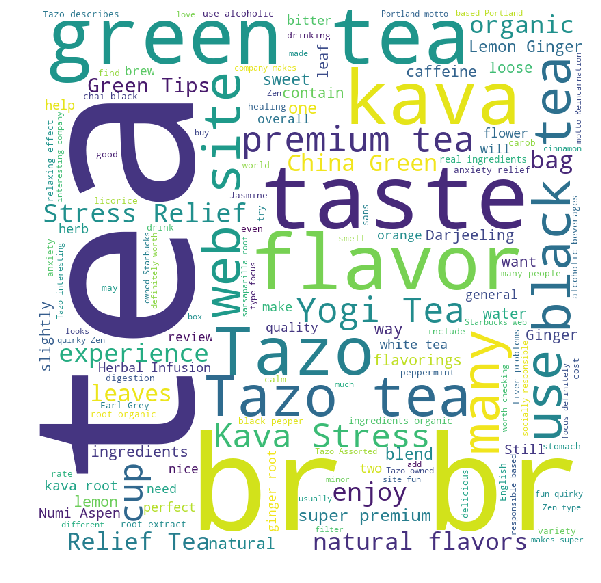

In [14]:
# 5th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[4]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

### KMedoids

* Algorithm for clustering related to KMeans.

In [15]:
from sklearn.metrics.pairwise import pairwise_distances

def Cal_squaredDis(clusters, centroids):
    squaredDis = 0
    for i in range(len(clusters)):
        for val in clusters[i]:
            squaredDis += pairwise_distances(bow_data[[val, centroids[i]]])[0][1]      
    return int(squaredDis)

Kmedoids code is from ( taken from https://github.com/letiantian/kmedoids )


originally from 
>Bauckhage C. Numpy/scipy Recipes for Data Science: k-Medoids Clustering[R]. Technical Report, University of Bonn, 2015.

In [16]:
from sklearn.metrics.pairwise import pairwise_distances
from CustomModules import kmedoids

D = pairwise_distances(bow_data, metric='euclidean')
squaredDis_s = []
for i in range(10, 16):
    centroids, clusters = kmedoids.kMedoids(D, i)
    sq_dis = Cal_squaredDis(clusters, centroids)
    squaredDis_s.append(sq_dis)

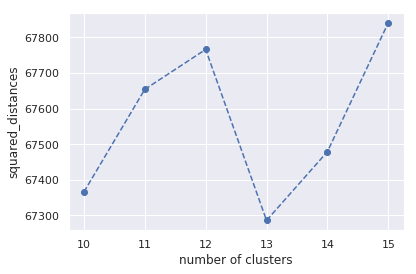

In [17]:
# plot 
te = [i for i in range(10, 16)]
plt.plot(te, squaredDis_s, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- Best model is of 12 clusters.

In [18]:
from CustomModules import kmedoids
from sklearn.metrics.pairwise import pairwise_distances

D = pairwise_distances(bow_data, metric='euclidean')
centroids, clusters = kmedoids.kMedoids(D, 12)

In [19]:
from prettytable import PrettyTable
from CustomModules import Dunn

labels = []
for i in range(bow_data.shape[0]):
    for j in range(len(clusters)):
        if i in clusters[j]:
            labels.append(j)
            break

dunn_index = Dunn.cal_dunnIndex(bow_data, centroids.reshape(-1,1), labels)
dis = Cal_squaredDis(clusters, centroids)
performence.append(['KMedoids', 12, round(dis, 2), 
                    round(dunn_index, 2)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [20]:
cluster_data = [[] for i in range(13)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [21]:
with open('Saved/cluter5.txt', 'w') as f:
    for sentence in cluster_data[4]:
        f.write(sentence)
        f.write('\n')
        
with open('Saved/cluter9.txt', 'w') as f:
    for sentence in cluster_data[8]:
        f.write(sentence)
        f.write('\n')

- Observed that text in cluster 2 has big size reviews.
- Cluster 4 have reviews about tea.

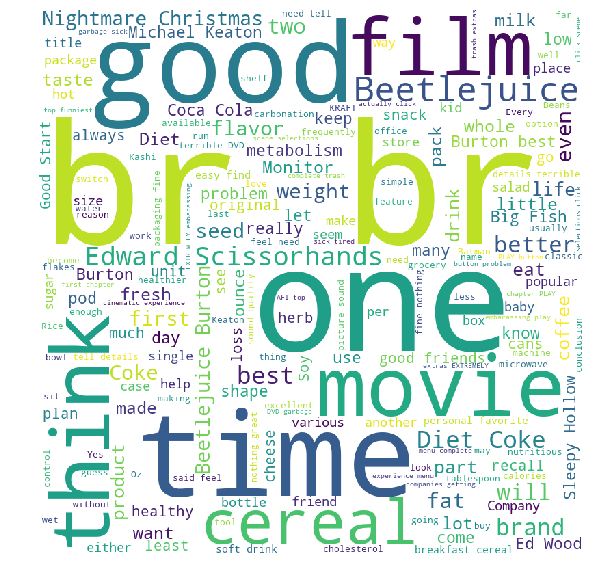

In [22]:
# 10th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[9]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

* We can observe most reviewers used cat in their reviews.

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [24]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=2000)
tfidf_data = tfidf_model.fit_transform(data)

## Clustering 

* Clustering text data into different clusters.
* Clustered using KMeans from sklearn.cluster module.
* Trained on Tf-idf data.

### KMeans++

* Algorithm for calculating intial values in KMeans.

In [25]:
from sklearn.cluster import KMeans

squared_distances = []
for i in range(8, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=3)
    kmeans.fit(tfidf_data)
    squared_distances.append(kmeans.inertia_)

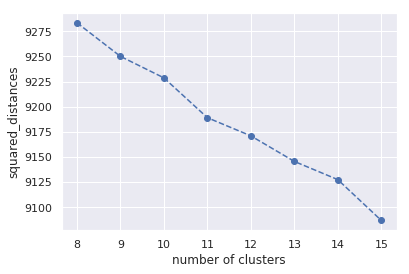

In [26]:
# plot 
te = [i for i in range(8,16)]
plt.plot(te, squared_distances, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- According to elbow method, best model is of 14 clusters.

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=14, init='k-means++', n_jobs=3)
kmeans.fit(tfidf_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
from prettytable import PrettyTable
from CustomModules import Dunn

dunn_index = Dunn.cal_dunnIndex(tfidf_data, kmeans.cluster_centers_, kmeans.labels_)
performence = []
performence.append(['Algo', 'num of clusters', 'squared distances', 'Dunn Index'])
performence.append(['KMeans++', 14, round(kmeans.inertia_, 2), 
                    round(dunn_index, 2)])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [29]:
# loading not preprocessed data
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')
original_data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)

# removing duplicates
original_data = original_data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

In [30]:
labels = kmeans.labels_
cluster_data = [[] for i in range(14)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [31]:
# saving 4th and 8th cluster data into text file
with open('Saved/cluter8.txt', 'w') as f:
    for sentence in cluster_data[4]:
        f.write(sentence)
        f.write('\n')
        
with open('Saved/cluter10.txt', 'w') as f:
    for sentence in cluster_data[8]:
        f.write(sentence)
        f.write('\n')

- Observed that text in cluster 8 has reviews about tea in positive manner.
- Cluster 10 has very large size reviews and positive opinions on product.

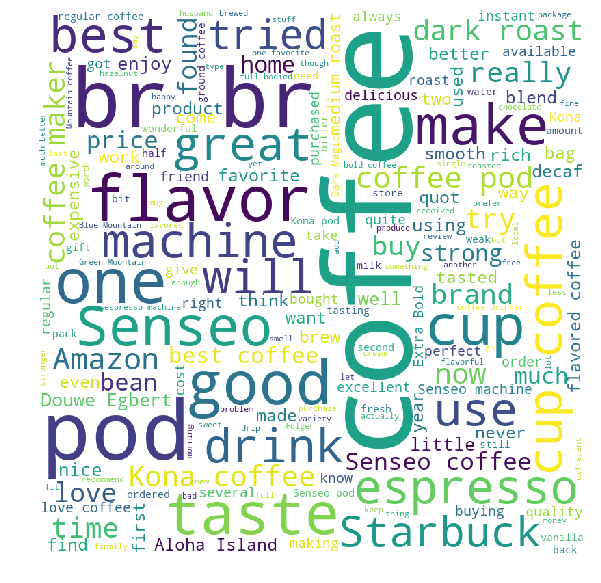

In [32]:
# 7th cluster wordcloud
from wordcloud import WordCloud
dt = ' '
for sen in cluster_data[6]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

* We can observe lot of reviews is about chocolate.

### KMedoids

* Algorithm for clustering related to KMeans.

In [33]:
from sklearn.metrics.pairwise import pairwise_distances

def Cal_squaredDis(clusters, centroids):
    squaredDis = 0
    for i in range(len(clusters)):
        for val in clusters[i]:
            squaredDis += pairwise_distances(tfidf_data[[val, centroids[i]]])[0][1]      
    return int(squaredDis)

In [34]:
from sklearn.metrics.pairwise import pairwise_distances
from CustomModules import kmedoids

D = pairwise_distances(tfidf_data, metric='euclidean')
squaredDis_s = []
for i in range(10, 16):
    centroids, clusters = kmedoids.kMedoids(D, i)
    sq_dis = Cal_squaredDis(clusters, centroids)
    squaredDis_s.append(sq_dis)

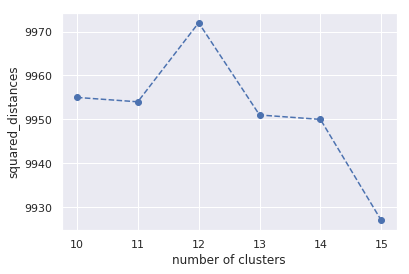

In [35]:
# plot 
te = [i for i in range(10, 16)]
plt.plot(te, squaredDis_s, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- Best model is of 12 clusters.

In [36]:
centroids, clusters = kmedoids.kMedoids(D, 12)

In [37]:
from prettytable import PrettyTable
from CustomModules import Dunn

labels = []
for i in range(tfidf_data.shape[0]):
    for j in range(len(clusters)):
        if i in clusters[j]:
            labels.append(j)
            break

dunn_index = Dunn.cal_dunnIndex(tfidf_data, centroids.reshape(-1,1), labels)
dis = Cal_squaredDis(clusters, centroids)
performence.append(['KMedoids', 12, round(dis, 2), 
                    round(dunn_index, 2)])

# Word2vec

* Trained own word2vec using gensim module. Considered words which has frequency more than 5 in whole data.
* Trained word2vec using Word2vec function from gensim.models.
* Trained for vector of size 150. And converted each word into a vector of size 150.
* Added all vectors of a sentence and divided with total number of vectors in sentence. So that we can get average word2vec value for each sentence.

In [39]:
# training word2vec on training data
from gensim.models import Word2Vec
sentences = []
for row in data:
    sentences.append([word for word in row.split()])

w2v = Word2Vec(sentences, min_count=5, size=150, workers=3)
avgw2v_data = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_data.append(te/num)

## Clustering 

* Clustering text data into different clusters.
* Clustered using KMeans from sklearn.cluster module.
* Trained on average word2vec data.

### KMeans++

* Algorithm for calculating intial values in KMeans.

In [40]:
from sklearn.cluster import KMeans

squared_distances = []
for i in range(10, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=3)
    kmeans.fit(avgw2v_data)
    squared_distances.append(kmeans.inertia_)

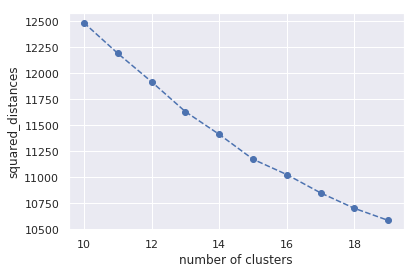

In [41]:
# plot 
te = [i for i in range(10, 20)]
plt.plot(te, squared_distances, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- According to elbow method, best model is of 15 clusters.

In [42]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, init='k-means++', n_jobs=3)
kmeans.fit(avgw2v_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
from prettytable import PrettyTable
from CustomModules import Dunn

dunn_index = Dunn.cal_dunnIndex(np.array(avgw2v_data), kmeans.cluster_centers_, kmeans.labels_)
performence = []
performence.append(['Algo', 'num of clusters', 'squared distances', 'Dunn Index'])
performence.append(['KMeans++', 15, round(kmeans.inertia_, 2), 
                    round(dunn_index, 2)])

### KMedoids

* Algorithm for clustering related to KMeans.

In [44]:
avgw2v_data = np.array(avgw2v_data)

In [45]:
from sklearn.metrics.pairwise import pairwise_distances

def Cal_squaredDis(clusters, centroids):
    squaredDis = 0
    for i in range(len(clusters)):
        for val in clusters[i]:
            squaredDis += pairwise_distances(avgw2v_data[[val, centroids[i]]])[0][1]      
    return int(squaredDis)

In [46]:
from sklearn.metrics.pairwise import pairwise_distances
from CustomModules import kmedoids

D = pairwise_distances(avgw2v_data, metric='euclidean')
squaredDis_s = []
for i in range(10, 16):
    centroids, clusters = kmedoids.kMedoids(D, i)
    sq_dis = Cal_squaredDis(clusters, centroids)
    squaredDis_s.append(sq_dis)

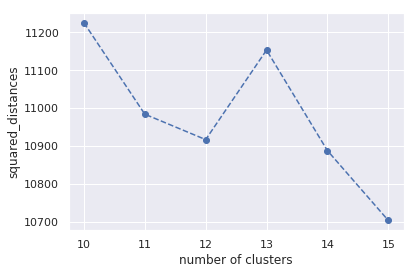

In [47]:
# plot 
te = [i for i in range(10, 16)]
plt.plot(te, squaredDis_s, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- Best model is of 13 clusters.

In [48]:
centroids, clusters = kmedoids.kMedoids(D, 13)

In [49]:
from prettytable import PrettyTable
from CustomModules import Dunn

labels = []
for i in range(avgw2v_data.shape[0]):
    for j in range(len(clusters)):
        if i in clusters[j]:
            labels.append(j)
            break

dunn_index = Dunn.cal_dunnIndex(avgw2v_data, centroids.reshape(-1,1), labels)
dis = Cal_squaredDis(clusters, centroids)
performence.append(['KMedoids', 13, round(dis, 2), 
                    round(dunn_index, 2)])

# Tf-IDF word2vec

* Using pre-trained tf-idf vectors and word2vec of size 150.
* Multiplying each word's word2vec vector and tf-idf value of that word in respected sentence.
* Executing above step for each word in a sentence and took sum of values of all words in a sentence.
* And this sum is divided by sum of tf-idf values of all words in sentences. Finally gives tf-idf word2vec values of size 150 for each sentence.

In [51]:
tfidf_data = tfidf_data.toarray()

In [52]:
sentences = []
for row in data:
    sentences.append([word for word in row.split()])

tfidfw2v_data = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_data.append(te)
    i = i + 1

## Clustering 

* Clustering text data into different clusters.
* Clustered using KMeans from sklearn.cluster module.
* Trained on tfidf word2vec data.

### KMeans++

* Algorithm for calculating intial values in KMeans.

In [53]:
from sklearn.cluster import KMeans

squared_distances = []
for i in range(10, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=3)
    kmeans.fit(tfidfw2v_data)
    squared_distances.append(kmeans.inertia_)

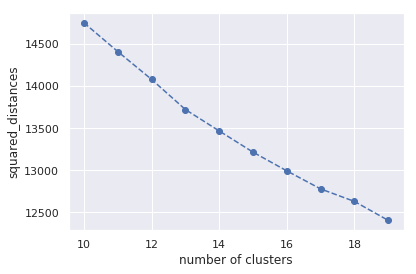

In [54]:
# plot 
te = [i for i in range(10, 20)]
plt.plot(te, squared_distances, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- According to elbow method, best model is of 16 clusters.

In [55]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16, init='k-means++', n_jobs=3)
kmeans.fit(tfidfw2v_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=16, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
from prettytable import PrettyTable
from CustomModules import Dunn

dunn_index = Dunn.cal_dunnIndex(np.array(tfidfw2v_data), kmeans.cluster_centers_, kmeans.labels_)
performence = []
performence.append(['Algo', 'num of clusters', 'squared distances', 'Dunn Index'])
performence.append(['KMeans++', 16, round(kmeans.inertia_, 2), 
                    round(dunn_index, 2)])

### KMedoids

* Algorithm for clustering related to KMeans.

In [57]:
tfidfw2v_data = np.array(tfidfw2v_data)

In [58]:
from sklearn.metrics.pairwise import pairwise_distances

def Cal_squaredDis(clusters, centroids):
    squaredDis = 0
    for i in range(len(clusters)):
        for val in clusters[i]:
            squaredDis += pairwise_distances(tfidfw2v_data[[val, centroids[i]]])[0][1]      
    return int(squaredDis)

In [59]:
from sklearn.metrics.pairwise import pairwise_distances
from CustomModules import kmedoids

D = pairwise_distances(tfidfw2v_data, metric='euclidean')
squaredDis_s = []
for i in range(10, 16):
    centroids, clusters = kmedoids.kMedoids(D, i)
    sq_dis = Cal_squaredDis(clusters, centroids)
    squaredDis_s.append(sq_dis)

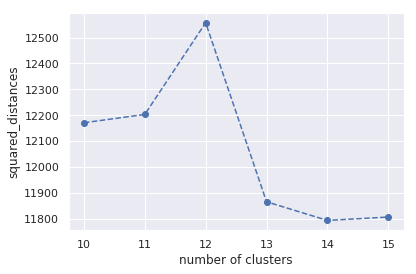

In [60]:
# plot 
te = [i for i in range(10, 16)]
plt.plot(te, squaredDis_s, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- Best model is of 15 clusters.

In [61]:
centroids, clusters = kmedoids.kMedoids(D, 15)

In [62]:
from prettytable import PrettyTable
from CustomModules import Dunn

labels = []
for i in range(tfidfw2v_data.shape[0]):
    for j in range(len(clusters)):
        if i in clusters[j]:
            labels.append(j)
            break

dunn_index = Dunn.cal_dunnIndex(tfidfw2v_data, centroids.reshape(-1,1), labels)
dis = Cal_squaredDis(clusters, centroids)
performence.append(['KMedoids', 15, round(dis, 2), 
                    round(dunn_index, 2)])

# Conclusion

In [23]:
print("Clustering with bag of words performence: ")
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names = performence[0]

for i in range(1, len(performence)):
    tb.add_row(performence[i])
print(tb)

Clustering with bag of words performence: 
+----------+-----------------+-------------------+------------+
|   Algo   | num of clusters | squared distances | Dunn Index |
+----------+-----------------+-------------------+------------+
| KMeans++ |        13       |     568181.72     |    0.04    |
| KMedoids |        12       |       67324       |    0.19    |
+----------+-----------------+-------------------+------------+


In [38]:
print("Clustering with tf-idf performence: ")
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names = performence[0]

for i in range(1, len(performence)):
    tb.add_row(performence[i])
print(tb)

Clustering with tf-idf performence: 
+----------+-----------------+-------------------+------------+
|   Algo   | num of clusters | squared distances | Dunn Index |
+----------+-----------------+-------------------+------------+
| KMeans++ |        14       |      9113.16      |    0.12    |
| KMedoids |        12       |        9977       |   12.73    |
+----------+-----------------+-------------------+------------+


In [50]:
print("Clustering with average word2vec performence: ")
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names = performence[0]

for i in range(1, len(performence)):
    tb.add_row(performence[i])
print(tb)

Clustering with average word2vec performence: 
+----------+-----------------+-------------------+------------+
|   Algo   | num of clusters | squared distances | Dunn Index |
+----------+-----------------+-------------------+------------+
| KMeans++ |        15       |      11221.46     |    0.15    |
| KMedoids |        13       |       11135       |   10.16    |
+----------+-----------------+-------------------+------------+


In [63]:
print("Clustering with tfidf word2vec performence: ")
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names = performence[0]

for i in range(1, len(performence)):
    tb.add_row(performence[i])
print(tb)

Clustering with tfidf word2vec performence: 
+----------+-----------------+-------------------+------------+
|   Algo   | num of clusters | squared distances | Dunn Index |
+----------+-----------------+-------------------+------------+
| KMeans++ |        16       |      12978.38     |    0.16    |
| KMedoids |        15       |       11672       |   10.01    |
+----------+-----------------+-------------------+------------+


* Got less squared distances for word2vec models because of its small size of vector.

* Got better clustering for tfidf than compared to bag of words vectorization.
* Got better clustering for avg word2vec than compared to tfidf word2vec vectorization.